# CS541: Applied Machine Learning, Spring 2025, Lab 11
Lab 11 is an exercise that explores Self-supervised learning.
Self-supervised learning (SSL) is a machine learning technique that trains models using unlabeled data to generate supervisory signals, rather than relying on human-provided labels. Rather than relying on labeled datasets for supervisory signals, self-supervised models generate implicit labels from unstructured data. Self-supervised learning (SSL) is particularly useful in fields like computer vision and natural language processing (NLP) that require large amounts of labeled data to train Deep Learning models like CNN's or Transformers.

**Lab Grading**

Labs are hands-on exercises designed to provide guided experience in key concepts through this class.  You are graded based on in-lab participation (not correctness), and **are required to submit** your lab work after class, before Friday of that week.  *Make sure you fill out the attendence form before leaving class*.

For students who miss a lab, you can submit a make-up lab on gradescope by the Friday directly following the lab for partial credit.  Please see the syllabus for the lab grading policy.

*   https://arxiv.org/pdf/2002.05709
*   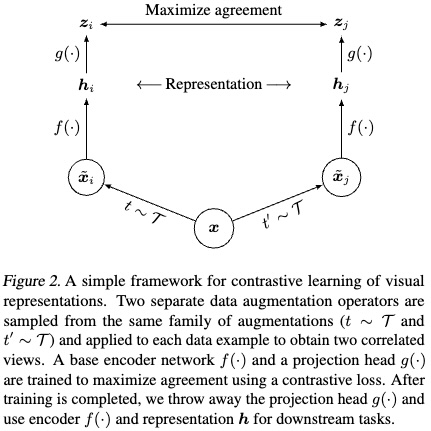

* 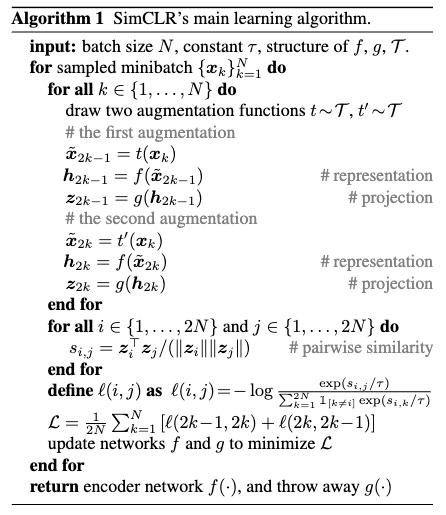

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torch.nn as nn
from torch.optim import lr_scheduler
import copy
import time
import os
import argparse
from google.colab import files
#from resnet import *
from torch.utils.data import Subset
import csv

device = 'cuda'

In [2]:
class Augment_train(object):
  def __init__(self,size):
    s = 0.5 # jitter strength
    size = 32
    color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)

    # Applies two independent random augmentations to it.
    self.train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply([color_jitter], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
      ])

  #  producing two different random views of the same image
  def __call__(self,x):
    transform = self.train_transforms

    xi = transform(x)
    xj = transform(x)
    return xi, xj


class Augment_eval(object):

  def __init__(self, size):
    size = 32

    self.eval_transforms = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    def __call__(self,x):
      transform = self.eval_transforms
      xi = transform(x)
      xj = transform(x)

      return xi,xj



dataset = torchvision.datasets.CIFAR10(
      root='./data', train=True, download=True, transform= Augment_train(32))


100%|██████████| 170M/170M [00:18<00:00, 9.47MB/s]


In [3]:
dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: <__main__.Augment_train object at 0x7d361c5bdc10>

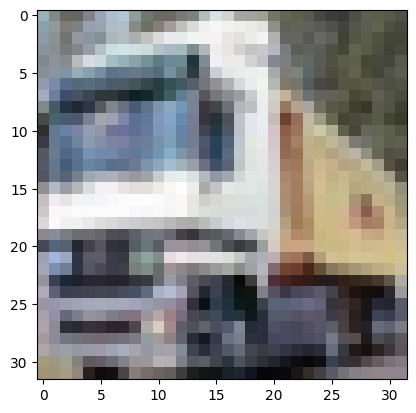

In [4]:
raw_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=None)

image, label = raw_dataset[1]  # get the first image and its label
plt.imshow(image)
plt.show()

In [5]:
# Create a subset with less data and equal distribution of classes
# taking a subset to make training faster and more manageable

with open('datalabel.txt', 'w',newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['current_class','label'])

def create_subset(ds):

  airplane_i, dog_i, deer_i, frog_i, cat_i, bird_i, horse_i, automobile_i, ship_i, truck_i = [], [], [], [], [],[],[],[],[],[]
  dog_idx, deer_idx, airplane_idx, frog_idx, cat_idx, bird_idx, automobile_idx, ship_idx, truck_idx, horse_idx = ds.class_to_idx['dog'], ds.class_to_idx['deer'],ds.class_to_idx['airplane'],ds.class_to_idx['frog'],ds.class_to_idx['cat'],ds.class_to_idx['bird'],ds.class_to_idx['automobile'],ds.class_to_idx['ship'],ds.class_to_idx['truck'],ds.class_to_idx['horse']
  label=[]
  for i in range(len(ds)):
    current_class = ds[i][1]
    if current_class == dog_idx:
      dog_i.append(i)
      label='dog'
    elif current_class == deer_idx:
      deer_i.append(i)
      label='deer'
    elif current_class == airplane_idx:
      airplane_i.append(i)
      label='airplane'
    elif current_class == frog_idx:
      frog_i.append(i)
      label='frog'
    elif current_class == cat_idx:
      cat_i.append(i)
      label='cat'
    elif current_class == bird_idx:
      bird_i.append(i)
      label='bird'
    elif current_class == automobile_idx:
      automobile_i.append(i)
      label='automobile'
    elif current_class == ship_idx:
      ship_i.append(i)
      label='ship'
    elif current_class == truck_idx:
      truck_i.append(i)
      label='truck'
    else:
      horse_i.append(i)
      label='horse'
    with open('datalabel.txt', 'a', newline='') as csvfile:
          writer = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
          writer.writerow([current_class, label])

  airplane_ui = airplane_i[:int(0.2 * len(airplane_i))]
  dog_ui = dog_i[:int(0.2 * len(dog_i))]
  deer_ui = deer_i[:int(0.2 * len(deer_i))]
  frog_ui = frog_i[:int(0.2 * len(frog_i))]
  cat_ui = cat_i[:int(0.2 * len(cat_i))]
  bird_ui = bird_i[:int(0.2 * len(bird_i))]
  horse_ui = horse_i[:int(0.2 * len(horse_i))]
  automobile_ui = automobile_i[:int(0.2 * len(automobile_i))]
  ship_ui = ship_i[:int(0.2 * len(ship_i))]
  truck_ui = truck_i[:int(0.2 * len(truck_i))]

  unlabelled_dataset = Subset(ds, airplane_ui+ dog_ui+ deer_ui+ frog_ui+ cat_ui+ bird_ui+ horse_ui+ automobile_ui+ ship_ui+ truck_ui)


  return unlabelled_dataset
# files.download('datalabel.txt')
unlabelled_dataset = create_subset(dataset)
print(len(unlabelled_dataset))

10000


In [6]:
# find the index of a specific class with label "x"
# datalabel.txt was generated earlier when we created the subset.
# It contains two columns: current_class (numeric index) and label (e.g., "frog").
# in_f.index gives you the row numbers in the CSV that belong to frogs.

import pandas as pd
stats = pd.read_csv('/content/datalabel.txt')
in_f= stats.loc[stats.label=='frog']
in_f.index


trainloader = torch.utils.data.DataLoader(
    unlabelled_dataset, batch_size=256, shuffle=True, num_workers=2)

# Takes a PyTorch tensor image, converts it to a NumPy array.
# Transposes it from [C, H, W] to [H, W, C] for matplotlib to display it correctly.
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

plt.figure(figsize=(16,16))

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

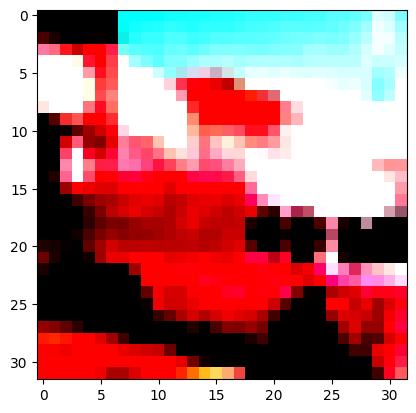

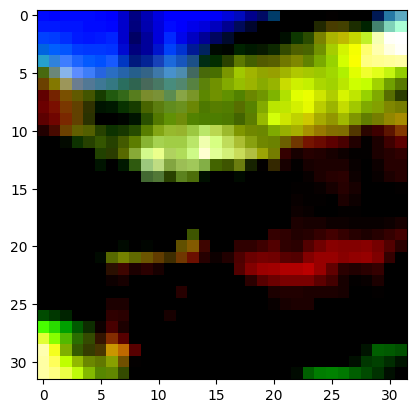

In [8]:
# visualize augmented images

for images, labels in trainloader:
    imshow(images[0][1])
    imshow(images[1][1])
    # print(images[1])
    # print(classes[labels[1].item()])
    # print()
    break

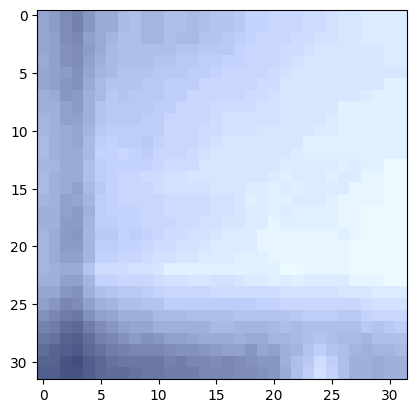

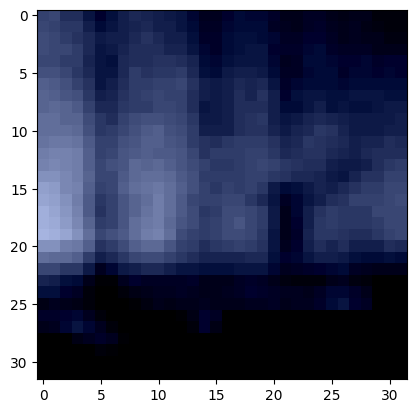

In [9]:
for images, labels in trainloader:
    imshow(images[0][1])
    imshow(images[1][1])
    # print(images[1])
    #print(classes[labels[1].item()])
    print()
    break

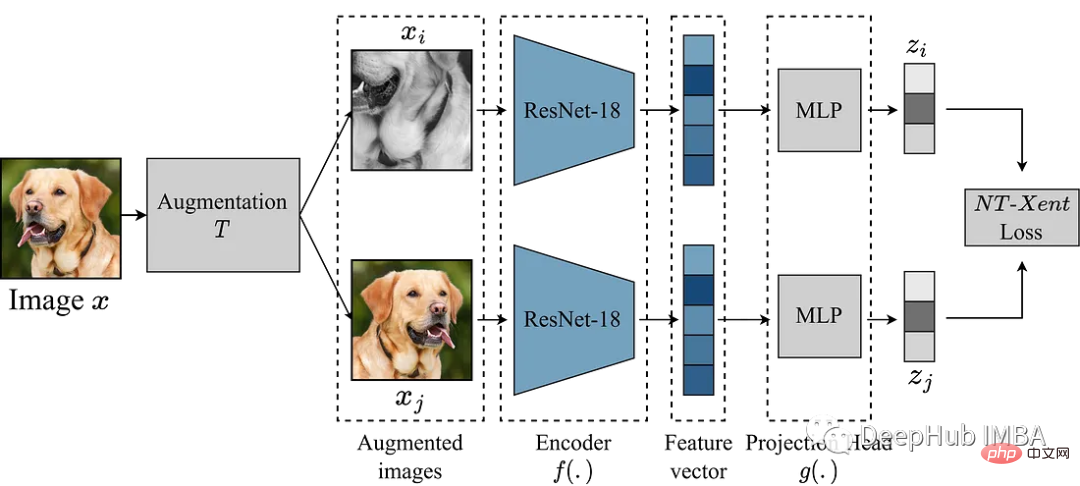


*   https://arxiv.org/pdf/2002.05709

* 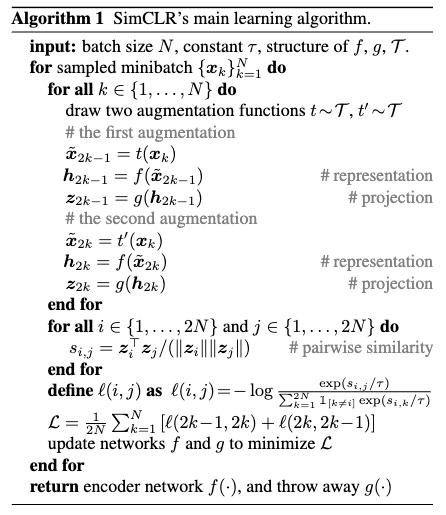

In [62]:
#  Normalized Temperature-Scaled Cross Entropy Loss
class NTXent_L(nn.Module):
  def __init__(self,batch_size,temperature=0.5):
      super().__init__()
      self.batch_size=batch_size
      self.temperature = temperature

  def cosine_sim(self, output1, output2): #output1, output2 as 2 augmented versions of image; shape:[B, D]
    # Here we concatenate the two outputs along the first dimension using pytorch
    o_con = torch.cat([output1, output2], dim = 0)
    # We use the cosine-similairty function from pytorch and use x_1 as o_con utilize the unsqueeze method
    # and add extra dimenion at 1 and use x_2  as o_con and add a dimension at 0 using the unsqueeze
    # For the cosine-simialtiy function we use the dimension to be 2 -> [2B, 2B]
    return torch.cosine_similarity(o_con.unsqueeze(1), o_con.unsqueeze(0), dim=2)

  def forward(self, z_i, z_j):

    batch_size= z_i.shape[0]

    # Call the cosine-similaity method we defined about on z_i and z_j
    # sim_m shape: [2B, 2B]
    # This is a similarity matrix between:
    # top half: embeddings from view 1 (z_i)
    # bottom half: embeddings from view 2 (z_j)
    # So, sim_m[i][j] tells you the similarity between sample i and sample j.
    sim_m = self.cosine_sim(z_i, z_j)

    # Get the diagonal above the main diagonal of the sim_m variable and use the offset as the batch_size using the torch diagonal method
    sim_ij = torch.diag(sim_m, batch_size)
    # Get the diagonal below the main diagonal of the sim_m variable and use the offset as the -(batch_size) using the torch diagonal method
    sim_ji = torch.diag(sim_m, -batch_size)

    # Here we concatenate the sim_ij and sim_ji along the first dimension
    sim_con = torch.cat([sim_ij, sim_ji], dim=0)
    # Here we get the exponential of the (sim_con divided by the temperature class variable)
    pos = torch.exp(sim_con/self.temperature)

    # Create a tensor with rows of size batch_size*2 and columns of size batch_size*2, with ones on the diagonal and zeros elsewhere
    # Then invert this so it will have zeros along the diagonal and ones elsewhere (maybe look at torch.eye)
    # we want to ignore self-similarities when computing negatives.
    mask = (~torch.eye(batch_size*2, batch_size*2, dtype=bool)).float()
    # Set neg to be the mask multipled by exponential of the (sim_m divided by the temperature class variable)
    # You maybe need to send the mask to the gpu
    neg = mask.to(device) * torch.exp(sim_m/self.temperature)
    # The loss is the (sum of the negative log of (pos variable divided by the sum of the columns of the variable neg))
    # Divided by the batch_size class variable multipled by 2
    loss = torch.sum(-torch.log(pos/torch.sum(neg, dim=1))) / (2*self.batch_size)

    return loss

In [63]:
(~torch.eye(1 *5 ,1*5, dtype=bool)).float()


tensor([[0., 1., 1., 1., 1.],
        [1., 0., 1., 1., 1.],
        [1., 1., 0., 1., 1.],
        [1., 1., 1., 0., 1.],
        [1., 1., 1., 1., 0.]])

In [64]:

criterion = NTXent_L(batch_size=256, temperature = 0.5)
criterion = criterion.to(device)


In [65]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


class SimCLR_model(nn.Module):

    def __init__(self, base_encoder, projection_dim, n_features):
        super(SimCLR_model, self).__init__()

        # Assign the corresponding base_encoder and n_features
        self.base_encoder = base_encoder
        self.n_features = n_features
        self.projection_dim = projection_dim

        #  the last layer is fc, which maps from the final hidden feature (e.g., 2048 in ResNet50) to 1000 classes for ImageNet.
        # But we don’t want classification in SimCLR. We want to use the raw feature representation before classification.
        # Let the base encoder fully connected layer be the Identity class we define above
        self.base_encoder.fc = Identity()
        self.projectionHead = nn.Sequential(
            # Create a linear layer with the input features be the n_features and the output features to be the n_features,
            # Also set the bias = False
            nn.Linear(self.n_features, self.n_features, bias=False),
            # Create a 1D BatchNorm layer with the num_features to be n_features
            nn.BatchNorm1d(self.n_features),
            # Add a relu layer
            nn.ReLU(), #non-linearity
            # Create a linear layer with the input features be the n_features and the output features to be the projection_dim,
            # Also set the bias = False
            nn.Linear(self.n_features, self.projection_dim, bias=False),
            # Create a 1D BatchNorm layer with the num_features to be projection_dim
            nn.BatchNorm1d(self.projection_dim),
        )

    def forward(self, x_i, x_j):
        # Pass the x_i into the base-encoder class variable
        h_i = self.base_encoder(x_i)
        #Pass the x_j into the base-encoder class variable
        h_j = self.base_encoder(x_j)

        # Pass the h_i into the Projection-Head class variable
        z_i = self.projectionHead(h_i)
        # Pass the h_j into the Projection-Head class variable
        z_j = self.projectionHead(h_j)

        return h_i, h_j, z_i, z_j

In [66]:
#base_encoder = ResNet50()
base_encoder = models.resnet50(pretrained=True)

projection_dim=128



In [67]:
print(base_encoder)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [68]:
#n_features= base_encoder.linear.in_features
net= SimCLR_model(base_encoder, projection_dim, 2048)
net= net.to(device)
#net

In [69]:


#Mounted at /content/gdrive

batch_size = 256
lr = 0.3*batch_size/256
start_epoch=0
max_epoch=301
optimizer= torch.optim.SGD(net.parameters(), lr)


# net.base_encoder.linear.weight

In [70]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    s=0
    tot_loss = 0
    total = 0
    batch_idx=0
    i=0
    batch_num =1
    for batch_idx, (images, targets) in enumerate(trainloader):
        #print("in batch", batch_num)
        batch_num=batch_num+1
        images[0], images[1], labels = images[0].to(device),images[1].to(device), targets.to(device)
        optimizer.zero_grad()

        h_i, h_j, z_i, z_j = net(images[0], images[1])
        loss= criterion(z_i,z_j)

        loss.backward()

        optimizer.step()

        tot_loss += loss.item()
        #print('batch loss', loss.item())

    print("epoch loss=",tot_loss)

    if epoch % 25 ==0:
        #modelstate_save_name = 'modelstate_bs_restart_r.pt'
        #path_modelstate = F"/content/gdrive/MyDrive/{modelstate_save_name}"
        #torch.save(net.state_dict(), path_modelstate)

        parameters_end = {
            #'net': net.state_dict(),
            'epoch': epoch,
            'loss': tot_loss
      }
        print('parameters_end')
        print(parameters_end)
        #paramsend_save_name = 'paramsend_bs_restart_r.pt'
        #path_paramsend = F"/content/gdrive/MyDrive/{paramsend_save_name}"
        #torch.save(parameters_end, path_paramsend)

for epoch in range(start_epoch, start_epoch+max_epoch):
  train(epoch)



Epoch: 0
epoch loss= 213.9702099710703
parameters_end
{'epoch': 0, 'loss': 213.9702099710703}

Epoch: 1
epoch loss= 202.18436087667942

Epoch: 2
epoch loss= 198.789523974061

Epoch: 3
epoch loss= 197.10140398144722

Epoch: 4
epoch loss= 196.05976389348507

Epoch: 5
epoch loss= 194.99291418492794

Epoch: 6


KeyboardInterrupt: 

# Now let's do the same thing but with ResNet 101 and see how the training loss changes